In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import random
import seaborn as sns

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'

runDir1 = 'v1.evaluateExpectedVersusInteresting_NlaIII_GM12878_2/'
plotDir1 = f'{dataDir}{runDir1}Plots_chr8/'
outDir1 = f'{dataDir}{runDir1}dfs_chr8/'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF, dfToDict
from incidenceToProjection import makeHiC_fromInc, fillInGaps_realData, makeNorm_HiC_fromInc
from edgeWeightFormulations import finalBounded
from promethData_multiwayExpectedProbs import cutoffEval

In [2]:
card = 3

coSimFile_gm = pd.read_csv(f'{outDir1}cosineSim_card{card}.csv',sep = "\t")
empDistFile_gm = pd.read_csv(f'{outDir1}empDist_card{card}.csv',sep = "\t")

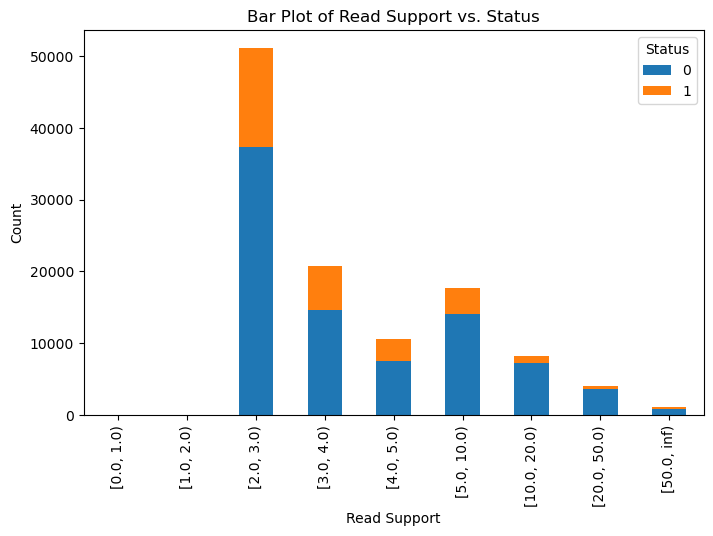

In [3]:
empDistFile = empDistFile_gm.copy()

bins = [0, 1, 2, 3, 4, 5, 10, 20,50, float('inf')]
empDistFile['ReadSupportBin'] = pd.cut(empDistFile['ReadSupport'], bins=bins, right=False)
grouped_empDist = empDistFile.groupby(['ReadSupportBin', 'Status']).size().unstack(fill_value=0)

# Plot the bar plot
ax = grouped_empDist.plot(kind='bar', stacked=True, figsize=(8, 5))

# Set labels and title
ax.set_xlabel('Read Support')
ax.set_ylabel('Count')
ax.set_title('Bar Plot of Read Support vs. Status')

# Show the plot
plt.show()

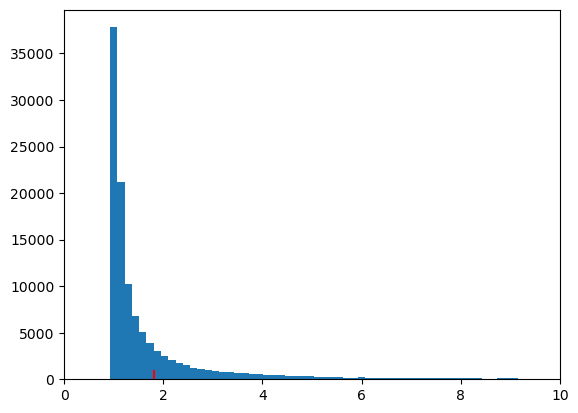

In [4]:
def getCutoff(summaryDF,quartile):
    q = f'{quartile}%'
    cutoff = pd.Series(summaryDF['mean']).describe()[q]
    return(cutoff)


empDistFile = empDistFile_gm.copy()

summary_empDist = empDistFile.filter(like="Sub").apply(lambda row: [np.mean(row), np.std(row)], axis=1, result_type='expand')
summary_empDist.columns = ['mean','sd']
empdistCutoff = getCutoff(summary_empDist,75)
p = plt.hist(summary_empDist['mean'],bins=5000)
plt.xlim(0,10)
plt.vlines(empdistCutoff, ymin = 0, ymax=1000,colors="red")
plt.show()
empdistStatus = [1 if x else 0 for x in (summary_empDist['mean'] >= empdistCutoff)]

In [5]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "empDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(coSimFile_gm['Status'], empdistStatus)]

Text(0.5, 0.98, '3Sub2')

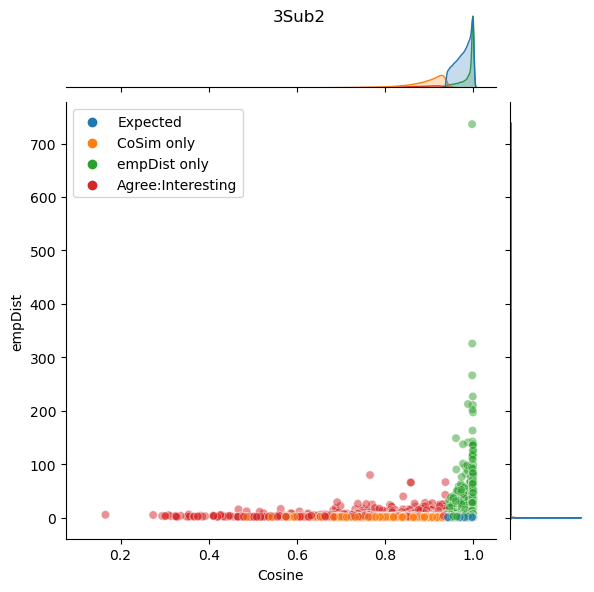

In [6]:
legend_order = ["Expected","CoSim only", "empDist only","Agree:Interesting"]

#plt.figure(figsize=(8, 4))
cos = coSimFile_gm['3Sub2']
empDist = empDistFile_gm['3Sub2']
j1 = sns.jointplot(x=cos, y=empDist, kind="scatter", 
                   hue=agreement_status, hue_order=legend_order, alpha = 0.5)
j1.set_axis_labels('Cosine', 'empDist', fontsize=10)
j1.fig.suptitle("3Sub2")
#axes[0].set_title('5Sub2')

In [7]:
with open(f'{dataDir}{runDir1}hyperEdges_GM12878_chr8.pkl','rb') as f:
    hpEdges = pickle.load(f)

# with open(f'{dataDir}{runDir2}hyperEdges_HCC1954_chr8.pkl','rb') as f:
#     hpEdges = pickle.load(f)

print("Processing all the hyperedges from pickle file")
hpKeys = [k for k in hpEdges.keys()]
keyCard = [len(k.split("_")) for k in hpKeys]
print("A total of",len(hpKeys),"initial interactions")

readSupport = [v for v in hpEdges.values()]
cE = cutoffEval(keyCard,readSupport)
# passedReadIx = cE.runForAllCards()
# updatedDict = {hpKeys[i]:readSupport[i] for i in passedReadIx}
atLeastTwoChains = [i for i,x in enumerate(readSupport) if x >=2]
updatedDict = {hpKeys[i]:readSupport[i] for i in atLeastTwoChains}

hpKeys = [k for k in updatedDict.keys()]
hpKeys_split = [k.split("_") for k in updatedDict.keys()]
keyCard = [len(item) for item in hpKeys_split]

Processing all the hyperedges from pickle file
A total of 950578 initial interactions


In [8]:
print(len(agreement_status))
consensusIx = [coSimFile_gm['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Agree:Interesting"]
print(len(consensusIx))
randList = random.sample(range(coSimFile_gm.shape[0]),len(consensusIx))

subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

113678
5888


In [9]:
subsetDict = {key: updatedDict[key] for key in subsetKeys}
subset_incDF = dictToDF(subsetDict)
finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [10]:
rsubsetKeys = [hpKeys[ix] for ix in randList]
rsubsetKeyCard = [keyCard[ix] for ix in randList]
rsubsetDict = {key: updatedDict[key] for key in rsubsetKeys}
rsubset_incDF = dictToDF(rsubsetDict)

randomBoundedScores = [finalBounded(list(rsubset_incDF[c])) for c in rsubset_incDF.columns]

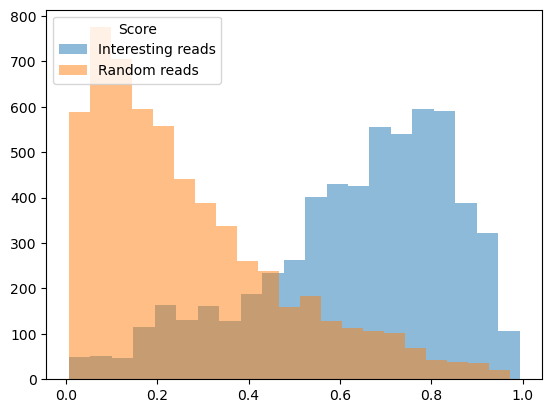

In [11]:
plt.hist(finalBoundedScores,bins = 21,alpha =0.5)
plt.hist(randomBoundedScores,bins = 21,alpha =0.5)
plt.legend(title="Score",loc="upper left",labels = ("Interesting reads","Random reads"))

In [12]:
fullDF = fillInGaps_realData(subset_incDF,"Bin",1)
projMat = makeHiC_fromInc(fullDF)

In [13]:
np.fill_diagonal(projMat.values, 0)

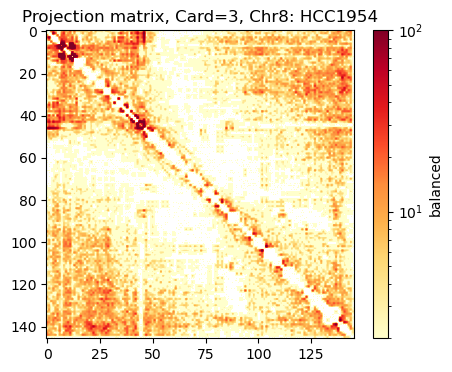

In [14]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm(vmax = 100))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Chr8: HCC1954")
plt.show()

In [15]:
projMat_norm_gm = projMat / np.nanmax(projMat)

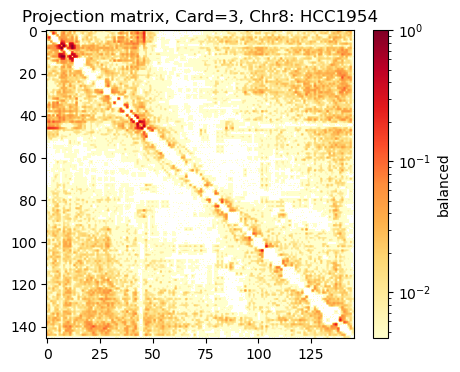

In [16]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat_norm_gm, cmap="YlOrRd",norm = LogNorm())
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Chr8: HCC1954")
plt.show()

In [18]:
impReads_gm = {}
impReads_gm = dfToDict(subset_incDF,impReads_gm)
print(list(impReads_gm.keys())[0:4])

['Bin3_Bin33_Bin145', 'Bin18_Bin87_Bin93', 'Bin33_Bin41_Bin139', 'Bin2_Bin41_Bin145']


In [19]:
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}NlaIII_GM12878_output_byChr/NlaIII_GM12878_chr8.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed_gm = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

In [21]:
chrFile = fullBed_gm[fullBed_gm['chr']=="chr8"]
binSize = 1*10**6 #5*10**5
chrBins = [x for x in range(0,chromSizes['chr8']+binSize,binSize)]
chrFile_binned = pd.cut(chrFile['start'],bins = chrBins, labels = ["Bin"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
binStart = [chrBins[i] + 1 for i in chrFile_binned.cat.codes]
binEnd = [chrBins[i+1] for i in chrFile_binned.cat.codes]
chrFile_wBinID = chrFile.assign(binID=chrFile_binned, binStart=binStart, binEnd=binEnd)

In [22]:
groupedBins = chrFile_wBinID.groupby('ID')['binID'].apply(list).reset_index(name='Bins')

def sort_key(item):
    return int(item.split('Bin')[1])

edges = ["_".join(sorted(list(set(a)), key=sort_key)) for a in groupedBins['Bins'] if len(list(set(a))) > 1]
readIDs = [groupedBins.iloc[ix][0] for ix in range(len(groupedBins)) if len(list(set(groupedBins.iloc[ix][1]))) > 1]
print(len(edges))
print(len(readIDs))

3698227
3698227


In [23]:
impReadIDs_gm = [readIDs[i] for i,x in enumerate(edges) if x in impReads_gm]

In [26]:
impRecords_gm = chrFile_wBinID[chrFile_wBinID['ID'].isin(impReadIDs_gm)]
impRecords_gm.to_csv(path_or_buf=f'{outDir1}diffContactReads_chr8.tab.gz',index = False,sep = "\t",compression="gzip")

In [27]:
nuclearSEFile = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/2023_03_06_GM12878_cellularFractionData/v0.evaluateSplicingEfficiency/SE_AvgOverReps_NuclearSE_withStatus'
nucSE = pd.read_csv(nuclearSEFile,sep="\t")

In [28]:
nucSE.head()

,gene_ID,SE_var,Cytosolic,Nuclear,WholeCell,nucStatus
0,ENSG00000000419,0.001063,0.943271,0.891642,0.951967,High
1,ENSG00000000457,0.017272,0.897960,0.640562,0.815354,Medium
2,ENSG00000000460,0.000561,0.955136,0.907759,0.931873,High
3,ENSG00000000938,0.001399,0.922836,0.848781,0.894995,High
4,ENSG00000001036,0.010581,0.928505,0.731498,0.881335,Medium


In [31]:
clust_gm = list(set(chrFile_wBinID[chrFile_wBinID['ID'].isin(impReadIDs_gm)]['geneID']))
gm_genes_se = nucSE[nucSE['gene_ID'].isin(clust_gm)]['Nuclear']

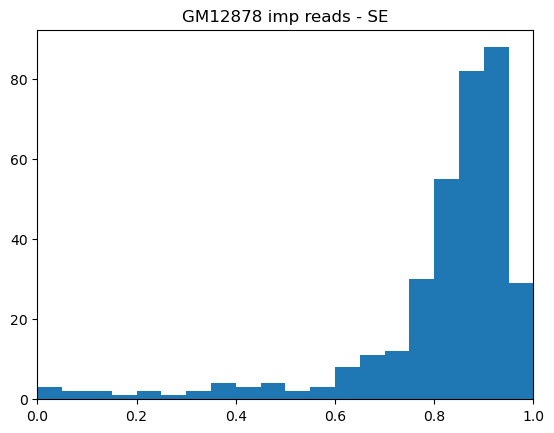

In [32]:
p = plt.hist(gm_genes_se,bins= 20)
plt.xlim(0,1)
plt.title("GM12878 imp reads - SE")
plt.show()

In [36]:
notImpGenes = list(set(chrFile_wBinID[~chrFile_wBinID['ID'].isin(impReadIDs_gm)]['geneID']))
len(notImpGenes)

1128

In [37]:
len(set(notImpGenes).difference(clust_gm))

30